In [63]:
# Had to download the MODFLOW executables separately from flopy from:
# https://github.com/MODFLOW-USGS/executables.
# I placed them in the top level of this git repo, under "executables"

import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

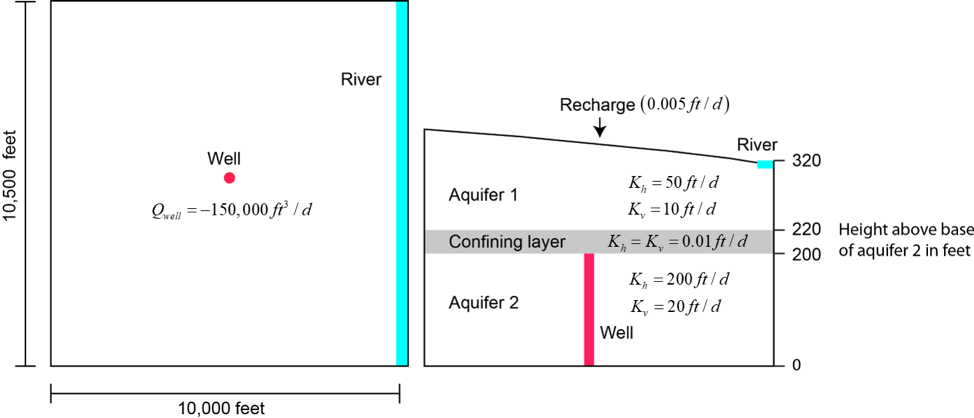

### Building and post-processing a MODFLOW 6 model

A MODFLOW 6 model will be developed of the domain shown above. This model simulation is based on example 1 in [Pollock, D.W., 2016, User guide for MODPATH Version 7—A particle-tracking model for MODFLOW: U.S. Geological Survey Open-File Report 2016–1086, 35 p., http://dx.doi.org/10.3133/ofr20161086](https://doi.org/10.3133/ofr20161086).

The model domain will be discretized into 3 layers, 21 rows, and 20 columns. A constant value of 500. will `delr` and `delc`. The top of the model should be set to 400 and the bottom of the three layers should be set to 220, 200, and 0. The model has one steady-state stress period. 

Create a simulation object, a time discretization object, and a iterative model solution object using `flopy.mf6.MFSimulation()`, `flopy.mf6.ModflowTdis()`, and `flopy.mf6.ModflowIms()`, respectively. Use default values for all iterative model solution variables.

* In MODFLOW-5, you'd build one model object with stuff within this. In MODFLOW-6, you can have multiple (i.e., nested) models, so the top level is a simulation object and models fit underneath that

Before creating the simulation object you should define the simulation workspace (`sim_ws`) where the model files are, the simulation name (`name`), and the name and path of the model executable (`exe_name`).  The `sim_ws` should be set to `'data/ex01b'`, `name` should be set to `ex01b`, and `exe_name` should be set to `bin/mf6`.

In [2]:
ws = 'work/ex01b' # workspace is a way to run several different simulations and save the output to different directories
name = 'ex01b'
exe_name = '../../executables/mf6.exe' # MODFLOW 6 needs to be in your path. I think mine must be thanks to whatever happend with the flopy installation.

In [3]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name = name, exe_name = exe_name, sim_ws = ws)

In [4]:
# create tdis package (time discretization - this is different than MODFLOW-5, you wouldn't need one there)
# Like ParFlow, units are whatever you give the inputs. 
# In this case, we'll be entering K in ft/d so out time units will be day
tdis = flopy.mf6.ModflowTdis(sim)


In [5]:
# create iterative model solution
# Lots of solver settings you can set here, but all have defaults as well
ims = flopy.mf6.ModflowIms(sim, complexity = 'moderate')

Create the gwf model object using `flopy.mf6.ModflowGwf()`. 

In MODFLOW 6 you can have multiple packages of the same type. You might use this to say, group all public wells in one well package. In the water budget you would see the public wells as a separate entry in the water budget. You could also turn off one of the well packages and see what happens without deleting those wells (easy to turn back on again too). Don't have to muck around with your main files when messing around with future scenarios, sensitivity analyses, etc.

In [6]:
gwf = flopy.mf6.ModflowGwf(sim, modelname = name)

Create the discretization package using `flopy.mf6.ModflowGwfdis()`.

In [7]:
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
# elevation of top layer. Could be an array with different elevations, e.g., from a raster
top = np.ones((nrow, ncol), dtype = np.float)*400. # can give it a single constant value or a numpy array like so.

# this is the bottom elevation of each layer. We have 3 layers.
botm = [220, 200, 0]

In [8]:
# We're making a regular structured model, but "disu" is unstructured, "disv" is horizontally unstructured but vertically layered
dis = flopy.mf6.ModflowGwfdis(gwf, nlay = nlay, nrow = nrow, ncol = ncol, 
                              delr = delr, delc = delc, top = top, botm = botm)

`flopy.plot.PlotMapView()` and `flopy.plot.PlotCrossSection()` can be used to confirm that the discretization is correctly defined.

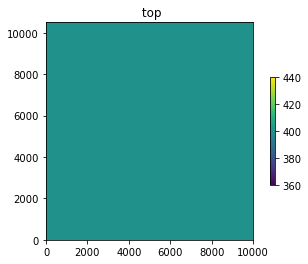

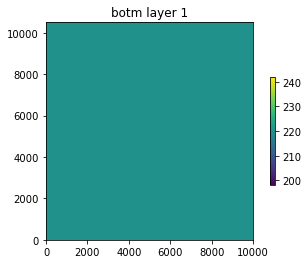

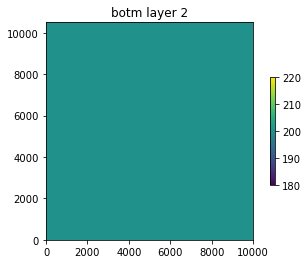

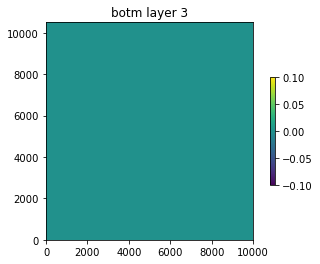

In [9]:
dis.plot() #plots everything that is an array type. 
# In a real-world model, you'd have different colors for the varying elevs in top  of the top layer, bottom of top layer, etc.

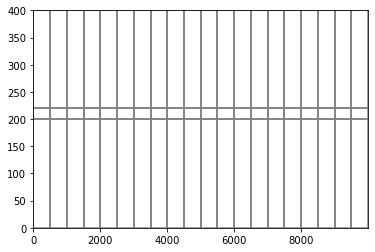

In [10]:
# Cross-section of model domain (cut at row 10)
xs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 10})
xs.plot_grid()

#### Create the initial conditions (IC) package

Create the discretization package using `flopy.mf6.ModflowGwfic()` and set the initial head (`strt`) to 320. Default values can be used for the rest of the initial conditions package input.

In [11]:
ic = flopy.mf6.ModflowGwfic(gwf, strt = 320)

#### Create the node property flow (NPF) package

The hydraulic properties for the model are defined in the image above. The first layer should be convertible (unconfined) and the remaining two layers will be non-convertible so `icelltype` should be `[1, 0, 0]`. The variable `save_specific_discharge` should be set to `True` so that specific discharge data are saved to the cell-by-cell file and can be used to plot discharge.

In [12]:
kh = [50, 0.01, 200]
kv = [10, 0.01, 20]
icelltype = [1, 0, 0]

In [13]:
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                             k = kh, k33 = kv, icelltype = icelltype)

#### Create the recharge package

The recharge rate is defined in the image above (0.005). Use the `flopy.mf6.ModflowGwfrcha()` method to specify recharge data using arrays.

In [14]:
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge = 0.005)

#### Create the well package

The well is located in layer 3, row 11, column 10. The pumping rate is defined in the image above.

In [15]:
# Dictionary of wells with time period, plus location of wells and pumping rate during that period. 
# Dictionary, list, tuple all at once!
# Will use the same pumping rate for the next periods until you turn it off
wel_spd = {0: [[(2, 10, 9), -150000]]}

wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data = wel_spd)

#### Create the river package

The river is located in layer 1 and column 20 in every row in the model. The river stage stage and bottom are at 320 and 318, respectively; the river conductance is 1e5.

In [16]:
stage = np.ones((nrow), dtype = np.float) * 320 # still constant, but as an array
stage = np.linspace(320, 320, nrow) # now it varies from from 320 to 320

In [17]:
# example of using a list comprehension on top of everything! Lots of layers to this input.
riv_spd = {0: [[(0, i, 19), stage[i], 1e5, 318] for i in range(nrow)]}
riv_spd

{0: [[(0, 0, 19), 320.0, 100000.0, 318],
  [(0, 1, 19), 320.0, 100000.0, 318],
  [(0, 2, 19), 320.0, 100000.0, 318],
  [(0, 3, 19), 320.0, 100000.0, 318],
  [(0, 4, 19), 320.0, 100000.0, 318],
  [(0, 5, 19), 320.0, 100000.0, 318],
  [(0, 6, 19), 320.0, 100000.0, 318],
  [(0, 7, 19), 320.0, 100000.0, 318],
  [(0, 8, 19), 320.0, 100000.0, 318],
  [(0, 9, 19), 320.0, 100000.0, 318],
  [(0, 10, 19), 320.0, 100000.0, 318],
  [(0, 11, 19), 320.0, 100000.0, 318],
  [(0, 12, 19), 320.0, 100000.0, 318],
  [(0, 13, 19), 320.0, 100000.0, 318],
  [(0, 14, 19), 320.0, 100000.0, 318],
  [(0, 15, 19), 320.0, 100000.0, 318],
  [(0, 16, 19), 320.0, 100000.0, 318],
  [(0, 17, 19), 320.0, 100000.0, 318],
  [(0, 18, 19), 320.0, 100000.0, 318],
  [(0, 19, 19), 320.0, 100000.0, 318],
  [(0, 20, 19), 320.0, 100000.0, 318]]}

In [18]:
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data = riv_spd)

#### Build output control

Define the output control for the model using the `flopy.mf6.ModflowGwfoc` method to `[('HEAD', 'ALL'), ('BUDGET', 'ALL')]` to save the head and flow for the model. Because we haven't set `SAVE_FLOWS` to `True` in all of the  packages we can set `.name_file.save_flows` to `True` for the groundwater flow model (`gwf`) to save flows for all packages that can save flows. Also the head (`head_filerecord`) and cell-by-cell flow (`budget_filerecord`) files should be set to `name+'.hds'` and `name+'.cbc'`, respectively.

In [19]:
hname = '{}.hds'.format(name)
cname = '{}.cbc'.format(name)
saverecord = [('HEAD', 'ALL'), ('BUDGET', 'ALL')]
oc = flopy.mf6.ModflowGwfoc(gwf, head_filerecord = hname, budget_filerecord = cname, saverecord = saverecord)

In [20]:
gwf.name_file.save_flows = True #in name file, writes a keyword that saves flows for all models

#### Write the model files and run the model

In [21]:
sim.write_simulation()
# outputs fortran stuff as 1-based, but input everything and process everything as 0-based in flopy

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model ex01b...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...


In [22]:
sim.run_simulation()

FloPy is using the following  executable to run the model: ../../executables/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resour

(True, [])

#### Post-process the results

Load the heads and face flows from the hds and cbc files. The head file can be loaded with the `flopy.utils.HeadFile()` method. The cell-by-cell file can be loaded with the `flopy.utils.CellBudgetFile()` method. MODFLOW 6 creates double precision binary files so `precision='double'` needs to be passed to the `flopy.utils.CellBudgetFile()` method. The `flopy.utils.HeadFile()` method autodetects the precision of the head file. The precision of the head file is a attribute on the head file object (`hobs.precision`) and could be passed as the `precision` parameter.

In [23]:
fpth = os.path.join(ws, hname)
hobj = flopy.utils.HeadFile(fpth)

In [24]:
hobj.get_kstpkper()

[(0, 0)]

In [25]:
hobj.get_times() # can loop over all times and get_data at those points

[1.0]

In [27]:
hds = hobj.get_data(totim = 1.0)  #3D numpy array of heads
hds.shape

(3, 21, 20)

In [28]:
fpth = os.path.join(ws, cname)
precision = hobj.precision
cbcobj = flopy.utils.CellBudgetFile(fpth, precision = precision)

The entries in the cell-by-cell file can be determined with the `.list_unique_records()` method on the cell budget file object.

In [31]:
cbcobj.list_unique_records()

RECORD           IMETH
----------------------
FLOW-JA-FACE         1
DATA-SPDIS           6
WEL                  6
RIV                  6
RCH                  6


Retrieve the `'DATA-SPDIS'` data type from the cell-by-cell file.

In [34]:
spd = cbcobj.get_data(totim = 1.0, text = 'DATA-SPDIS')[0]
spd

rec.array([(   1,    1, 0., 0.00555491, -0.00019318, -0.00363117),
           (   2,    2, 0., 0.00837229, -0.0002005 , -0.00361224),
           (   3,    3, 0., 0.01408894, -0.00021476, -0.00357376), ...,
           (1258, 1258, 0., 0.02824568,  0.00193241,  0.00225433),
           (1259, 1259, 0., 0.0192475 ,  0.0017113 ,  0.0034868 ),
           (1260, 1260, 0., 0.01403339,  0.00160052,  0.00497315)],
          dtype=[('node', '<i4'), ('node2', '<i4'), ('q', '<f8'), ('qx', '<f8'), ('qy', '<f8'), ('qz', '<f8')])

#### Plot the results

Plot the results using `flopy.plot.PlotMapView()`. The head results can be plotted using the `.plot_array()` method. The discharge results can be plotted using the `plot_specific_discharge()` method. Boundary conditions can be plotted using the `.plot_bc()` method.

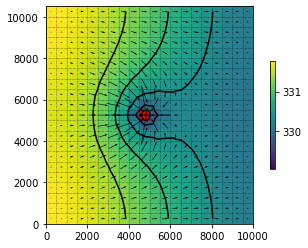

In [55]:
pltobj = flopy.plot.PlotMapView(model = gwf, layer = 2)
pltobj.plot_grid(lw = 0.5, color = "black", ls = ":") # can pass in a lot of the matplot keywords to customize plot
c = pltobj.plot_array(hds)
pltobj.contour_array(hds, colors = "black") # Contour lines
pltobj.plot_bc('RIV') # can add plotAll = True to see on all layers
pltobj.plot_bc('WEL')
plt.colorbar(c, shrink = 0.5)

pltobj.plot_specific_discharge(spd)

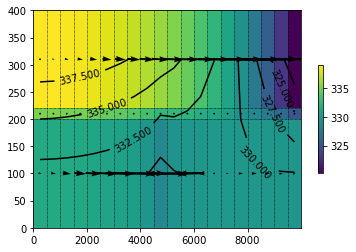

In [61]:
# Cross section plot
pltobj = flopy.plot.PlotCrossSection(model = gwf, line = {'row': 10})
pltobj.plot_grid(lw = 0.5, color = "black", ls = ":") # can pass in a lot of the matplot keywords to customize plot
c = pltobj.plot_array(hds)
cc = pltobj.contour_array(hds, colors = "black") # Contour lines
#pltobj.plot_bc('RIV') # can add plotAll = True to see on all layers
#pltobj.plot_bc('WEL')
plt.colorbar(c, shrink = 0.5)
plt.clabel(cc)

pltobj.plot_specific_discharge(spd)

In [62]:
ts = hobj.get_ts((0,0,0))
ts

array([[  1.        , 339.08931535]])